In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
from scipy.stats import linregress
from matplotlib.colors import LogNorm
from scipy.stats import ttest_ind
from scipy.signal import butter, filtfilt, sosfiltfilt
from scipy.stats import linregress

### ClIM680, Class Project
### Written by Tehreem Qureshi, MS Student in Climate Science

## <center> <b> Research Question: How Are Monthly Precipitation Anomalies Affected by Changes in External & Anthropogenic Warming and Are there Particular Hotspots of Interest? 
    Part I: Preprocessing precipitation monthly file, cleaning up units and dimensions, and calculating climatologies/anomalies.
    Part II: Analysis of Solar Flux Indices and Development of Composites with Statistical Significance.
    Part III: Analysis of Precipitation Sensitivity to Temperature Anomaly Changes as Evidenced by Regression
    Part IV: Identification of Vulnerable Region (New Guinea) based on Forcings in Part II and Part III and Visualization of Extreme Precipiation Events
    Part V: Next Steps

  



##  <center> <b> Part I: Preprocessing file and calculating climatologies.  <center> <b>

#### * Convert units from m to mm
#### * Shift lat/lon to (-90,90) and (-180, 180) respectively
#### [Link](https://cds.climate.copernicus.eu/datasets/derived-era5-single-levels-daily-statistics?tab=overview) to ERA5 precip dataset - note precipitation has been resampled into monthly sums from daily sums. The main dataset of this project is the EMCWF ERA5 Renalysis Dataset, which is resampled into monthly sums of precipitation (originally daily with units of m) at a global resolution of .25 x .25 degrees from 1979-2022.

In [3]:
filename = '/home/tquresh/clim680/monthly_precip_sum.nc' # monthly values of total precipitation (m) from 1979-2022
monthly_precip19792022 = xr.open_dataset(filename)
monthly_precip19792022 
monthly_precip19792022['tp'] = monthly_precip19792022['tp'] * 1000  # change to mm from m
monthly_precip19792022['tp'].attrs['units'] = 'mm'

# adjust lats and lons to go from -90 to 90 and -180 to 180 for easier plotting
monthly_precip19792022 = monthly_precip19792022.sortby('latitude')
monthly_precip19792022 = monthly_precip19792022.assign_coords(longitude=((monthly_precip19792022['longitude']+180) % 360)-180)
monthly_precip19792022 = monthly_precip19792022.sortby(monthly_precip19792022['longitude'])

In [4]:
monthly_precip19792022 # output to make sure everything worked

<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 528, latitude: 721, longitude: 1440)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2022-12-01
  * latitude    (latitude) float64 6kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * longitude   (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
    number      int64 8B ...
Data variables:
    tp          (valid_time, latitude, longitude) float32 2GB 1.172 ... 17.19

#### * Use groupby to calculate 1991-2020 climatology and and corresponding monthly anomalies. 
##### A climatology of 1991-2020 is selected for this project because it represents the most recent 30 year baseline, utilized by many up to date climate datasets to assess changing conditions.

In [5]:
precip_clim = monthly_precip19792022.sel(valid_time=slice('1991-01-01T00:00:00.000000000', '2020-12-01T00:00:00.000000000')).groupby('valid_time.month').mean() # select 1991-2020 and group by month, then take monthly means to compute climatology
precip_anoms = monthly_precip19792022.groupby('valid_time.month') - precip_clim # subtract monthly climatologies to get anomalies
precip_anoms # check output

<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 528, latitude: 721, longitude: 1440)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2022-12-01
  * latitude    (latitude) float64 6kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * longitude   (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
    number      (valid_time) int64 4kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    month       (valid_time) int64 4kB 1 2 3 4 5 6 7 8 9 ... 5 6 7 8 9 10 11 12
Data variables:
    tp          (valid_time, latitude, longitude) float32 2GB -2.463 ... 1.36

#### * Plot multi-panel plot of monthly 1991-2020 climatologies. 

/home/tquresh/miniforge/envs/clim680/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: Log scale: values of z <= 0 have been masked
  result = super().contourf(*args, **kwargs)
/home/tquresh/miniforge/envs/clim680/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: Log scale: values of z <= 0 have been masked
  result = super().contourf(*args, **kwargs)
/home/tquresh/miniforge/envs/clim680/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: Log scale: values of z <= 0 have been masked
  result = super().contourf(*args, **kwargs)
/home/tquresh/miniforge/envs/clim680/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: Log scale: values of z <= 0 have been masked
  result = super().contourf(*args, **kwargs)
/home/tquresh/miniforge/envs/clim680/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: Log scale: values of z <= 0 have been masked
  result = super().contourf(*args, **kwargs)
/home/tqur

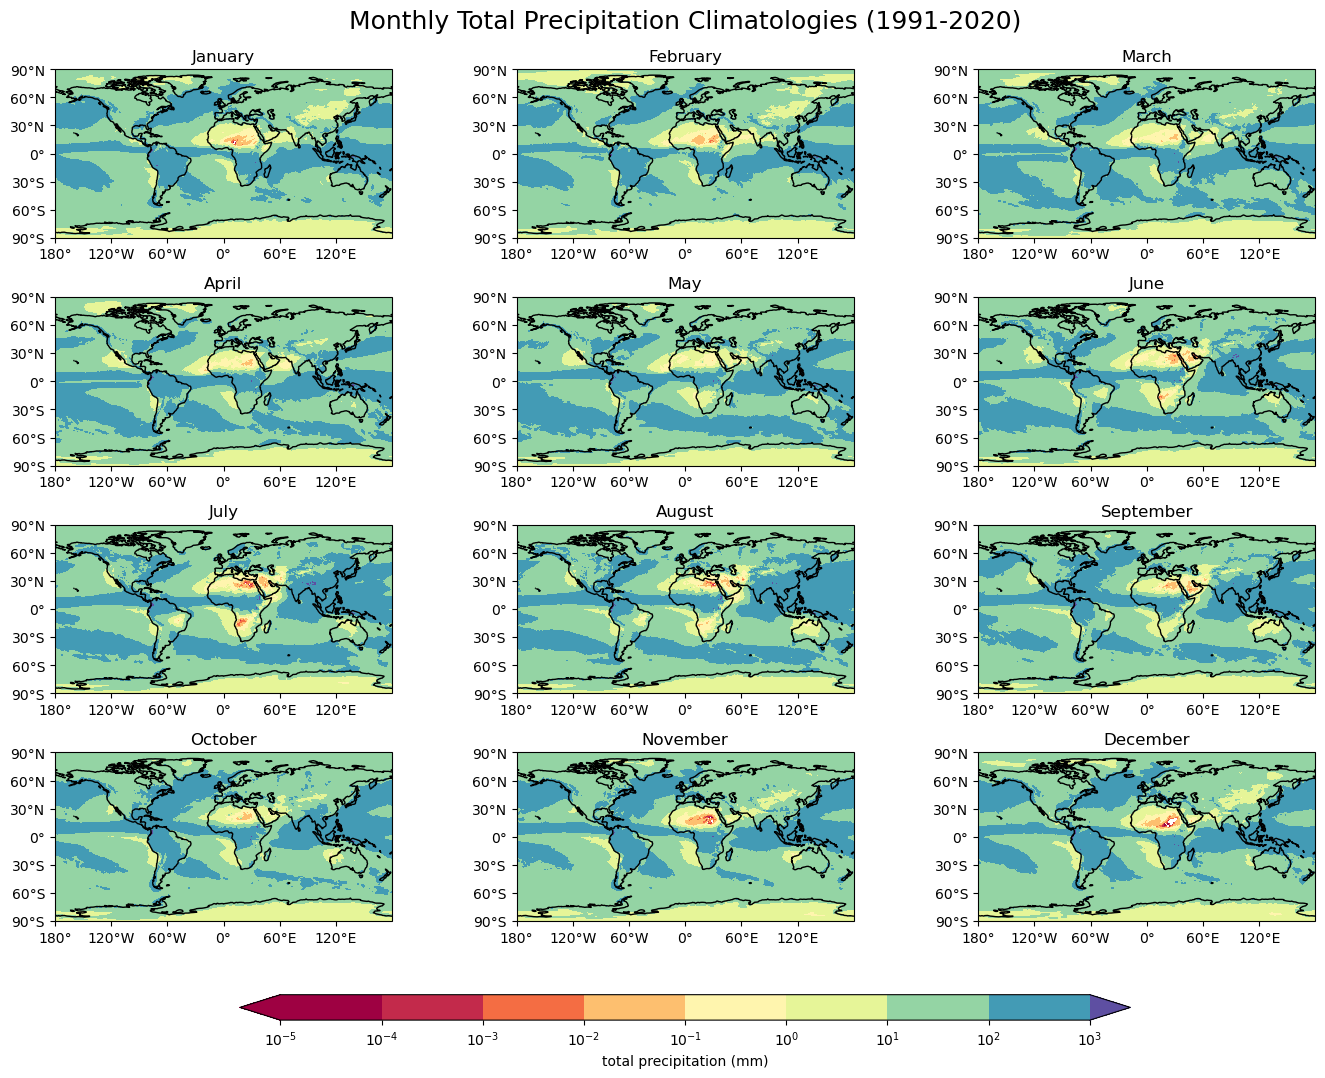

In [6]:
months=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

fg = precip_clim['tp'].plot.contourf(
    sharex=True,
    sharey=True,
    row='month', # each subplot represents a month
    col_wrap=3, # use three columns to space out evenly 
    robust=True,
    extend = 'both',
    norm=LogNorm(vmin=1e-4, vmax=precip_clim['tp'].values.max()), # use logNorm because precip anomalies have values of different magnitudes which a linear colorbar visualizes poorly. make sure to set a minimum close to 0 because you cannot have 0 as a value.
    cmap='Spectral', 
    subplot_kws={"projection": ccrs.PlateCarree()}, # projection  
    cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.65, # make colorbar slightly smaller
        "aspect": 35,
        "pad": .05,
        "label": "total precipitation (mm)",
    },
    figsize=(14, 12) # larger plots 
)

for ax in fg.axes.flat:
    ax.coastlines()
    ax.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.set_xlabel("") # remove lat labels for cleaner plot 
    ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_ylabel("") # remove lon labels for cleaner plot

for ax, month in zip(fg.axs.flat, months):
    ax.set_title(month) # this ensures the titles are months and not "month = " or by number
    
plt.subplots_adjust( # figures overlapping quite a bit in the original so adjust spacing
    top=0.93,   
    bottom=0.22,
    hspace=0.35,   
)
plt.suptitle("Monthly Total Precipitation Climatologies (1991-2020)", fontsize=18)
plt.show()

#### * Calculating global time series of monthly precipitation anomalies by weighting and averaging across lat/lon dimensions.

In [7]:
weights = np.cos(np.deg2rad(precip_anoms.latitude))
precips_weighted = precip_anoms.tp.weighted(weights) # weight latitude to take into consideration the change in grid cell size as latitude increases
precips_weighted # this will be used as a weighted array 
global_precipanomalies_weighted = precips_weighted.mean(dim=("longitude", "latitude"))

#### * Plot time series of monthly averages, rolling averages, and yearly trends to observe global changes over-time in precipipation. 
##### * Note the yearly average and linear regression use how the precip monthly average for the year - NOT yearly sums.

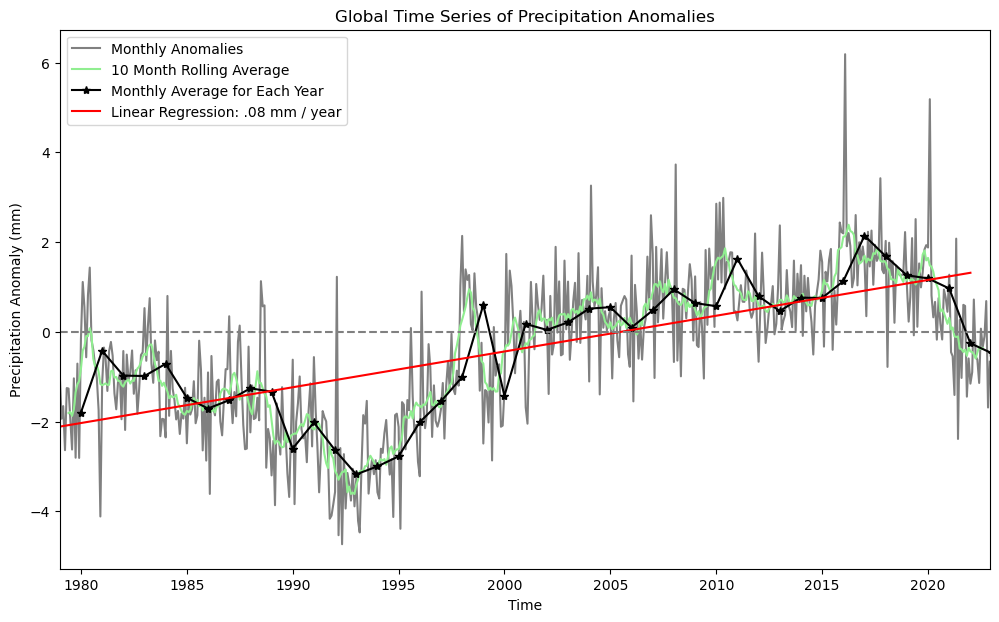

In [8]:
fig, ax =  plt.subplots(figsize=(12, 7))

# first  plot global anomalies and 10 month rolling average
global_precipanomalies_weighted.plot(label = 'Monthly Anomalies', color = 'grey') # plot time series of monthly anomalies
global_precipanomalies_weighted_rolling = global_precipanomalies_weighted.rolling(valid_time=10,center=True).mean().dropna(dim='valid_time') # take rolling 10-month mean
global_precipanomalies_weighted_rolling.plot(label = '10 Month Rolling Average', color = 'lightgreen')
plt.xlim(precip_anoms['valid_time'].min(), precip_anoms['valid_time'].max()) # fix x limit 


# second - plot yearly average of monthly precip anomalies and trendline 


global_yrly_avg = global_precipanomalies_weighted.resample(valid_time='1YE').mean() # compute yearly mean - this gives us average value of precipitation each month saw
global_yrly_avg.plot(label = 'Monthly Average for Each Year', marker = '*', color = 'black')


# to compute linear regression, do groupby instead for yearly averages to have .year as a value and not as datetime (otherwise will get an error)

global_yrly_avg_gb = global_precipanomalies_weighted.groupby('valid_time.year').mean()
m,b,r,p,e = linregress(global_yrly_avg_gb.year,global_yrly_avg_gb.values)
years = pd.to_datetime(global_yrly_avg_gb.year, format='%Y') # this fixes the datetime formatting so can plot on same plot 
plt.plot(years, m*global_yrly_avg_gb.year + b, label = 'Linear Regression: .08 mm / year', color = 'red') # note, this is not saying each year is getting .08 mm wetter - it is saying that the average monthly precipitation amount is getting .08 wetter per year. 
plt.legend()
plt.axhline(0, color='grey', linestyle='--')
plt.ylabel('Precipitation Anomaly (mm)')
plt.xlabel('Time')
plt.title('Global Time Series of Precipitation Anomalies')
plt.show()

### Interestingly, it appears that the late 20th century was drier and early 21st century was wetter globally if we use 1991-2020 baseline anomalies. Note we do have a short dataset (43 years), so more data is likely needed to validate long-term trends. The slight increase of .08 mm / year indicates that months may be getting wetter overtime, although this anomaly value is quite small and limited to the temporal frame.

##  <center> <b> Part II: Composite Analysis, Statistical Signifiance to Analyze Precipitation Against Solar Flux Forcing.  <center> <b>

### [Link](https://psl.noaa.gov/data/correlation/solar.data) to dataset. Here, I utilize a 10.7cm Solar Flux Indices dataset from the National Research Council of Canada, which records solar radio waves to utilize an external forcing.
    
### Note this dataset stores values of raw flux as x10 for integer storage. Divide by 10 before working with data to get in units of sfu.

In [9]:
# read in CSV that was downloaded from Google Sheets

solar_flux = pd.read_csv('/home/tquresh/classproject/SolarFluxIndices.csv')
solar_flux 

,Year,January,February,March,April,May,June,July,August,September,October,November,December
0,1948,1557,1343,1355,2081,2265,1955,1828,1728,1637,1591,1654,1933
1,1949,1835,2202,2039,1825,1549,1575,1599,1752,1725,1782,1804,1652
2,1950,1507,1433,1378,1643,1571,1287,1341,1209,986,999,1019,1011
3,1951,1079,1019,1025,1271,1686,1617,1163,1098,1178,1060,1044,1024
4,1952,954,862,785,840,809,848,888,933,815,828,834,857
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,2020,723,709,702,696,692,697,695,717,706,746,901,873
73,2021,901,873,761,743,765,747,798,810,779,901,866,1029
74,2022,1041,1091,1178,1306,1340,1161,1256,1181,1347,1328,1236,1485
75,2023,1825,1721,1575,1459,1560,1624,1775,1539,1557,1416,1544,1593


### * Read CSV into Xarray datarray. 

In [10]:
# note this code was adapted from my Assignment 3, where I used and validated output from AI for this block to read in a CSV into an Xarray data array with datetime stamps.  


fluxes = (
    solar_flux.set_index("Year")
      .stack()   
      .rename_axis(["Year", "Month"]) # instead of year and month columns, this stacks them so we can turn each row into a datetime value
      .reset_index(name="Solar Flux")
)

fluxes["time"] = pd.to_datetime(fluxes["Year"].astype(str) + "-" + fluxes["Month"] + "-01") # this makes the conversion much easier because it automatically takes the "stack" and converts to datetime 

fluxes_da = xr.DataArray(
    fluxes ["Solar Flux"].where(fluxes["Solar Flux"] != -999), # get rid of NaNs 
    coords={"valid_time": fluxes["time"]},
    dims=["valid_time"],
    name="Solar Flux (sfu)"
)
# -> end ChatGPT 

# select same timeframe as precip data 

fluxes_da = fluxes_da.sel(valid_time=slice('1979-01-01T00:00:00.000000000', '2022-12-01T00:00:00.000000000')) / 10 # this brings the csv from the website back into sfu units, whereas it is originally stored as ten times the original value for integer space storage

### *  Defining Thresholds and Creating Their Composites with Solar Flux and Calculating Statistical Significance

### From online research, it appears that there is no set definition for "strong" or "weak" solar fluxes. Therefore, I went with the thresholds below based on papers that used the term "strong" and "weak flux" and general ranges.  

### Strong Flux -> Flux ≥ 200 sfu 
### Normal Flux -> 200 sfu > Flux > 100 sfu 
### Weak Flux -> Flux ≤ 100 sfu 

In [11]:
strong_flux = fluxes_da.where(fluxes_da>=200) 
weak_flux = fluxes_da.where(fluxes_da<=100)
normal_flux = fluxes_da.where((fluxes_da>100) & (fluxes_da<200))

print('Strong Solar Flux: ',strong_flux.count(dim='valid_time').values)
print('Weak Solar Flux: ',weak_flux .count(dim='valid_time').values)
print ('Normal Flux: ' , normal_flux.count(dim='valid_time').values)

# confirm this has 528 time steps - consistent with our precip data

Strong Solar Flux:  54
Weak Solar Flux:  244
Normal Flux:  230


### * Plot Time Series of Solar Flux with Thresholds 

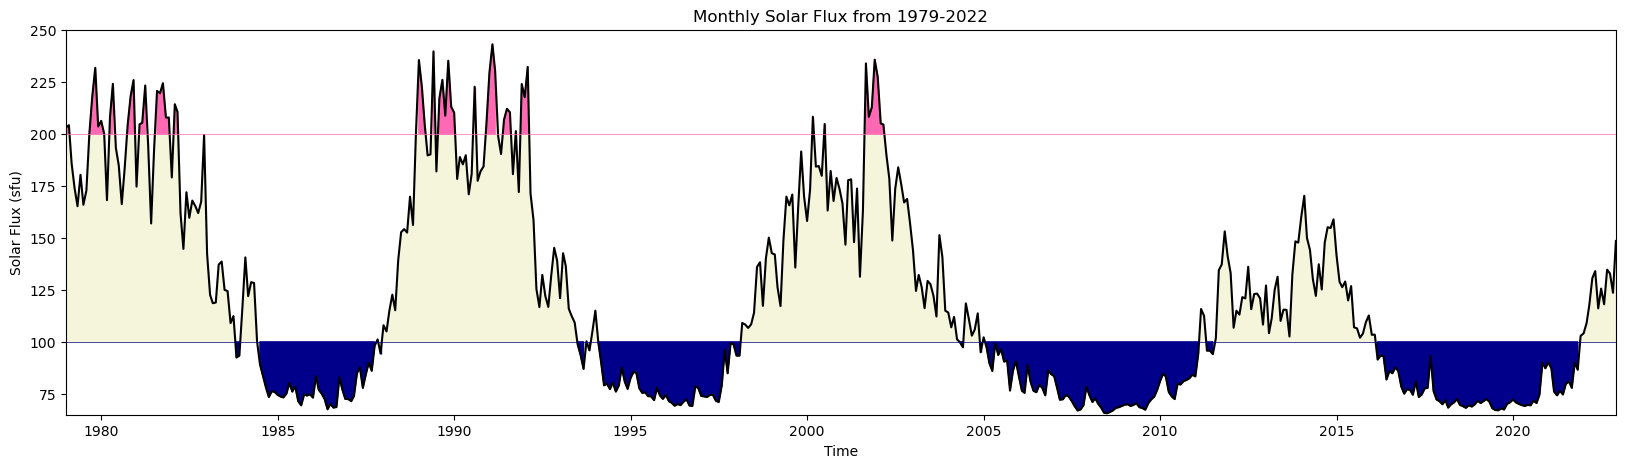

In [12]:
plt.figure(figsize=(20, 5))
plt.plot(fluxes_da['valid_time'],fluxes_da,'k')
plt.fill_between(fluxes_da['valid_time'].values,fluxes_da,y2 = 100, color='beige') # neutral
plt.fill_between(fluxes_da['valid_time'].values,strong_flux,y2=200,color='hotpink')
plt.fill_between(fluxes_da['valid_time'].values,weak_flux,y2=100,color='darkblue')
plt.axhline(100,color='darkblue',linewidth=0.5)
plt.axhline(200,color='hotpink',linewidth=0.5)
plt.title('Monthly Solar Flux from 1979-2022')
plt.ylabel('Solar Flux (sfu)')
plt.xlabel('Time')
plt.ylim(65, 250)
plt.xlim(fluxes_da['valid_time'].min(), fluxes_da['valid_time'].max())
plt.show()

### * Develop Composites of Precipitation Anomalies Based on Flux Thresholds 

### Composites allow for the visualization of conditions from another indices, which can provide insight on how conditions might look during strong or weak years of the chosen indices (although further statistical analysis is needed to make conclusions).

In [13]:
strongflux_precip = precip_anoms['tp'].sel(valid_time=strong_flux.dropna(dim='valid_time')['valid_time']).mean(dim='valid_time') # only select precip anomalies that are within threshold times, then average among selected times
weakflux_precip = precip_anoms['tp'].sel(valid_time=weak_flux.dropna(dim='valid_time')['valid_time']).mean(dim='valid_time')
normalflux_precip = precip_anoms['tp'].sel(valid_time=normal_flux.dropna(dim='valid_time')['valid_time']).mean(dim='valid_time')
comp_precip = [strongflux_precip, normalflux_precip,weakflux_precip] # different composites we will loop over

### * Plot Composites 

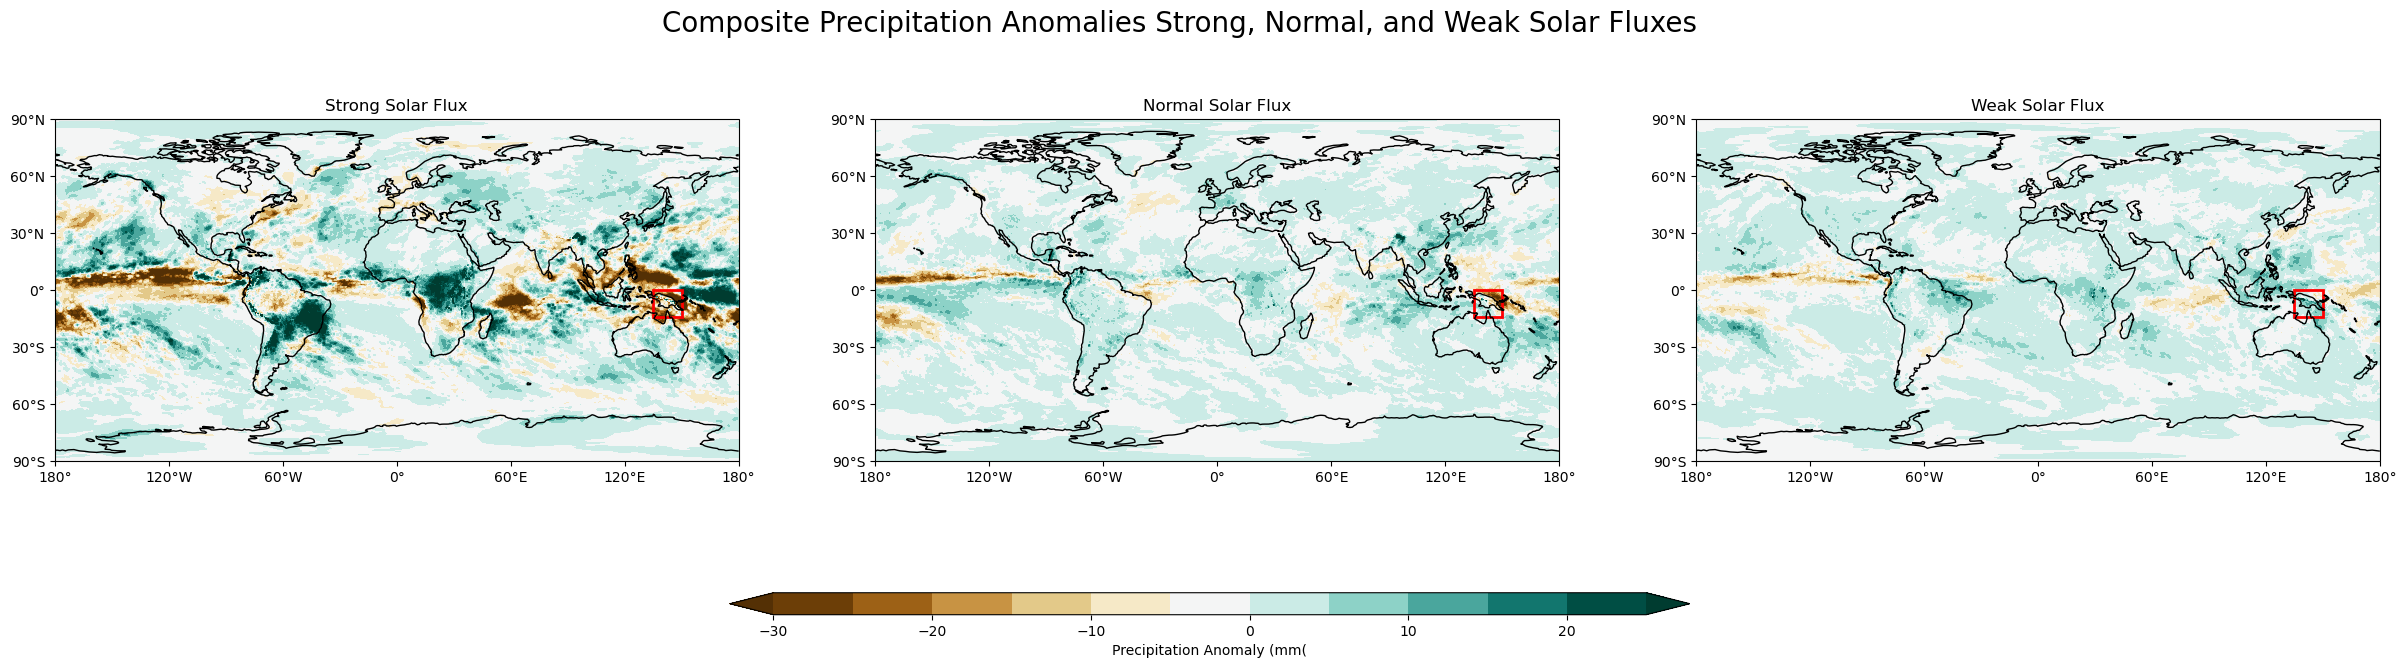

In [14]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # add patches to show region that is of interest in these plots

# going back after completing analysis to point out New Guinea region 

latitude_ng = slice(-14, 0)
longitude_ng = slice(135, 150)


labels=['Strong Solar Flux','Normal Solar Flux', 'Weak Solar Flux']
clevs = np.arange(-30, 30, 5) 

fig, axs = plt.subplots(nrows=1,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(30,11))

axs = axs.flatten()


for i,flux in enumerate(comp_precip):

        data = comp_precip[i]

        data,lons = add_cyclic_point(data,coord=comp_precip[i]['longitude'])

        cs=axs[i].contourf(lons,comp_precip[i]['latitude'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='BrBG',extend='both')

        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        axs[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        
        axs[i].set_title(labels[i])

        axs[i].coastlines()
        axs[i].add_patch(Rectangle((135, -14), 15, 14, fill=False,
        edgecolor='red',
        linewidth=2,
        transform=ccrs.PlateCarree() ))

cbar_ax = fig.add_axes([0.35, 0.2, 0.32, 0.02])
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='Precipitation Anomaly (mm(')
plt.suptitle('Composite Precipitation Anomalies Strong, Normal, and Weak Solar Fluxes', fontsize=20, y=.75)
plt.show()

### * Calculating and Plotting Composite Diffferences from Normal Flux Conditions for Both Strong and Weak Threshold 

### This is helpful to visualize differences between our extreme thresholds and normal conditions to see how composites change. This contextualizes the next step, which is the t-test for statistical significance. 

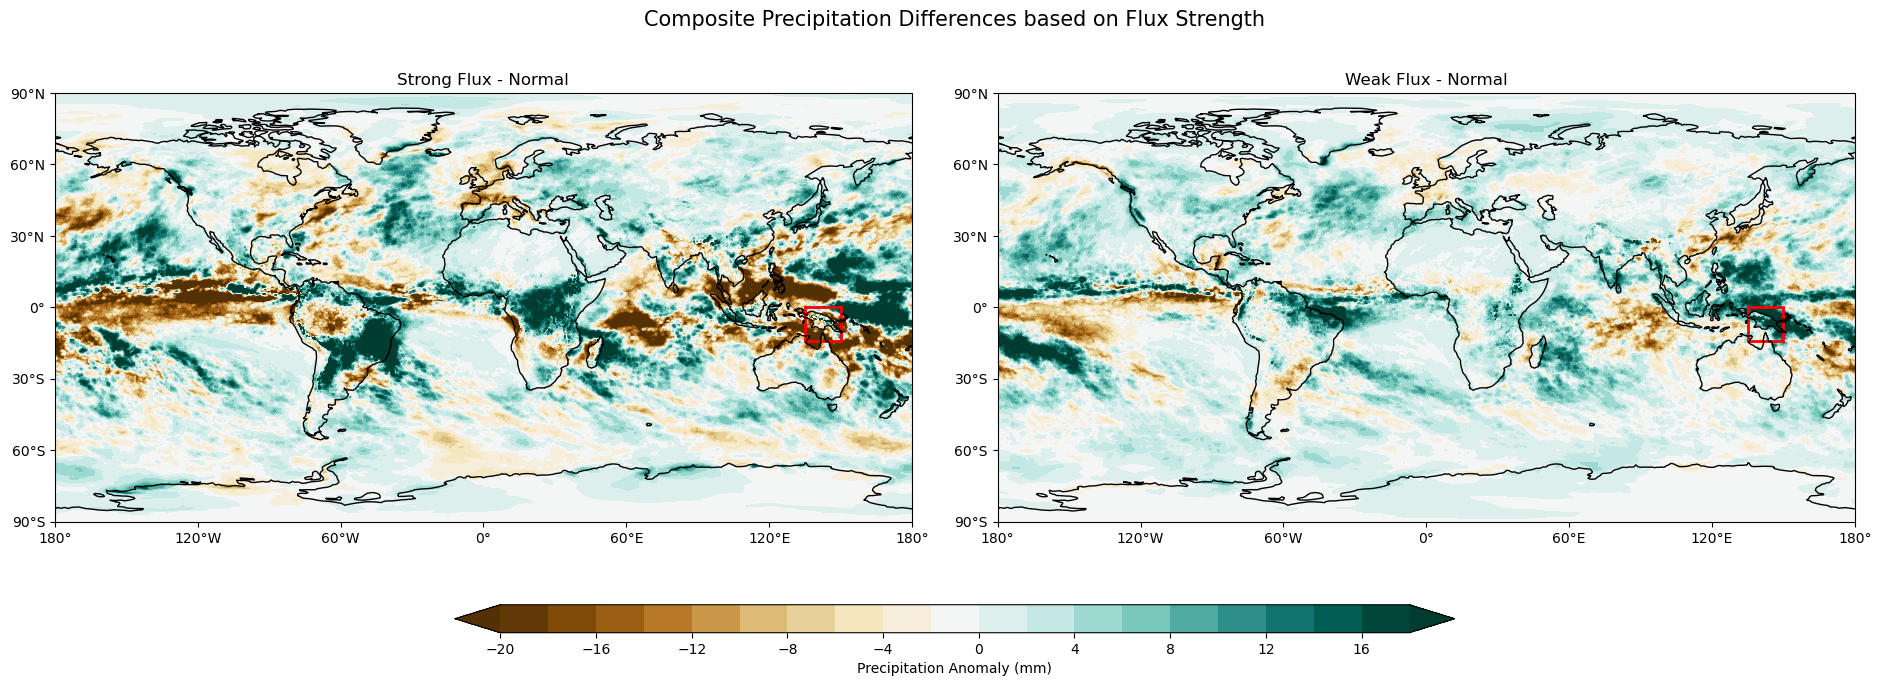

In [15]:
diff_precip = [strongflux_precip - normalflux_precip, weakflux_precip - normalflux_precip] 
labels=['Strong Flux - Normal','Weak Flux - Normal']
clevs=np.arange(-20, 20, 2)

fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(20,7))

axs = axs.flatten()

for i, flux in enumerate(diff_precip):

        data = diff_precip[i]

        data,lons = add_cyclic_point(data,coord=diff_precip[i]['longitude'])

        cs = axs[i].contourf(lons,diff_precip[i]['latitude'],data,clevs,
                          transform=ccrs.PlateCarree(),
                          cmap='BrBG',extend='both')

        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        axs[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        
        axs[i].set_title(labels[i])

        axs[i].coastlines()
        axs[i].add_patch(Rectangle((135, -14), 15, 14, fill=False,
        edgecolor='red',
        linewidth=2,
        transform=ccrs.PlateCarree() ))

fig.subplots_adjust(bottom=0.25, top=0.88, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

cbar_ax = fig.add_axes([0.25, 0.10, 0.5, 0.04])

cbar = fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='Precipitation Anomaly (mm)')

plt.suptitle('Composite Precipitation Differences based on Flux Strength', y = .99, fontsize = 15)
plt.show()

### * Getting arrays of precip anomaly dataset that is subsetted by flux threshold and conducting t-test. We conduct the t-test with the null hypothesis that the difference between the two means (where we have two cases: Strong Flux Precip Anomaly Composite and Neutral Flux Precip Anomaly Composite, and Weak Flux and Neutral Composite) is zero with a 95% confidence level.

In [16]:
strongflux_precip_vals = precip_anoms['tp'].sel(valid_time=strong_flux.dropna(dim='valid_time')['valid_time']) # aligning times as we did before, but this time not averaging over time spatial relationship
weakflux_precip_vals = precip_anoms['tp'].sel(valid_time=weak_flux.dropna(dim='valid_time')['valid_time'])
neutralflux_precip_vals = precip_anoms['tp'].sel(valid_time=normal_flux.dropna(dim='valid_time')['valid_time'])

p=.05 # p value indicates 95% confidence level

# TEST 1 

## calculate t-test for strong flux and neutral composites, call it with subscript 1 with the mask


tstat1,pval1=ttest_ind(strongflux_precip_vals, 
                weakflux_precip_vals, 
                equal_var = False) # assume no equal variance

mask_diff1 = diff_precip[0].where(pval1 <= p) # mask out regions of insignificance 
mask_diff1

# TEST 2
## calculate t-test for weak flux and neutral composites, call it with subscript 2 

tstat2,pval2=ttest_ind(weakflux_precip_vals, 
                neutralflux_precip_vals, 
                equal_var = False)

mask_diff2 = diff_precip[1].where(pval2 <= p) # mask out regions of insignificance 
mask_diff2

mask_diff = [mask_diff1, mask_diff2] # masks to be used in loop for plot

### * Plot Difference Composites and Add Hatches to Indicate Statistical Signifiance

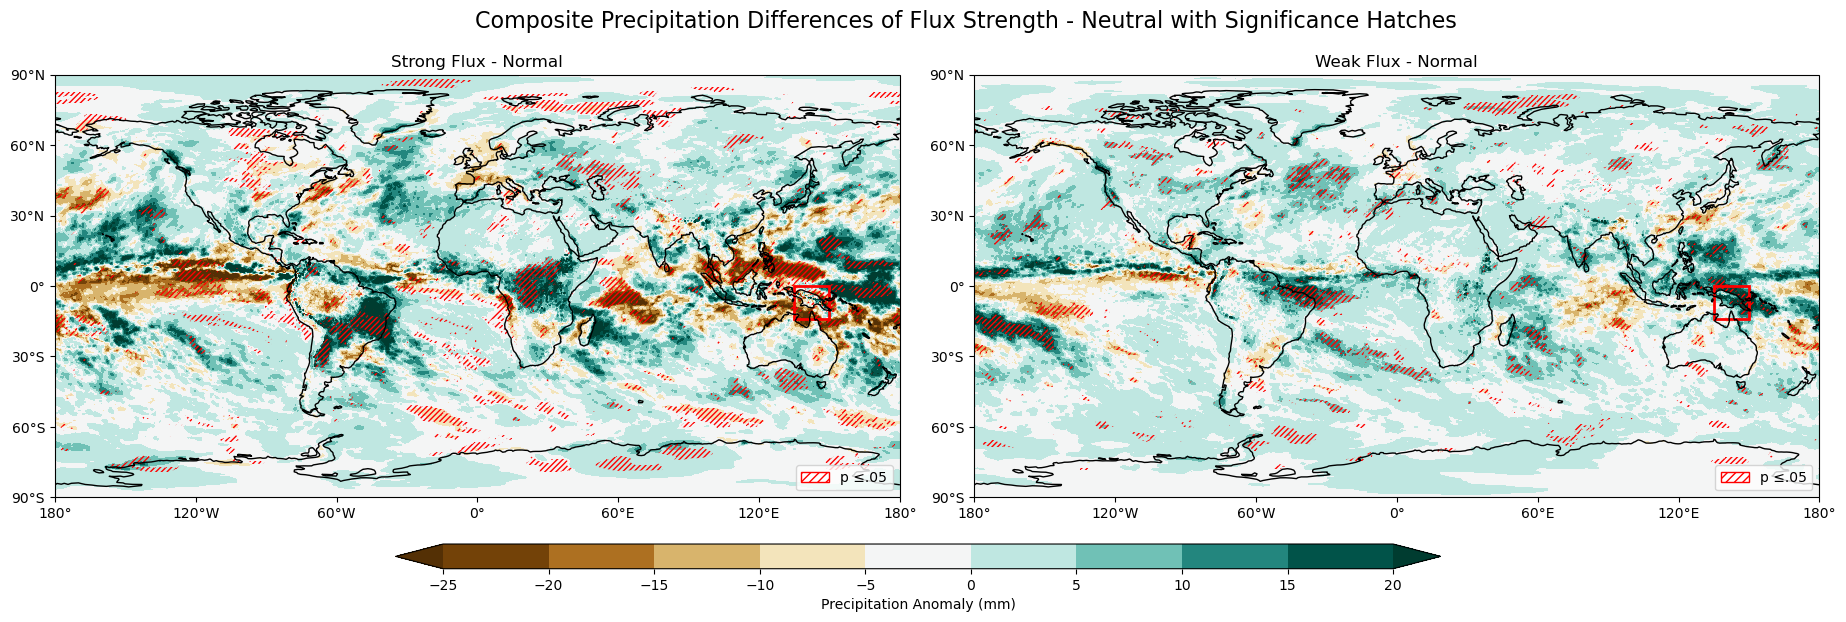

In [17]:
import matplotlib.patches as mpatches
import matplotlib as mpl
labels=['Strong Flux - Normal','Weak Flux - Normal']

clevs=np.arange(-25, 25, 5)
mpl.rcParams['hatch.color'] = 'red' # change hatch color for better visualization

fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(19,6.5))

for i, fluxes in enumerate(diff_precip):

    data=diff_precip[i] 

    data,lons=add_cyclic_point(data,coord=diff_precip[i]['longitude'])
    mask_data,lons=add_cyclic_point(mask_diff[i],coord=diff_precip[i]['longitude'])
    axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)

    axs[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter)


        
    cs = axs[i].contourf(lons,diff_precip[i]['latitude'],data,clevs,
                        transform = ccrs.PlateCarree(),
                        cmap='BrBG',extend='both')

    axs[i].contourf(lons,diff_precip[i]['latitude'],mask_data,[0,1], # this will mask all values of signifiance given that the contour fills are only from [0,1] -> will fill anything that is not NaN
                  transform = ccrs.PlateCarree(),colors='None',
                 hatches=['//////',''],extend='both', alpha=0) 
    
    axs[i].set_title(labels[i])
    axs[i].coastlines()
    axs[i].add_patch(Rectangle((135, -14), 15, 14, fill=False,
    edgecolor='red',
    linewidth=2,
    transform=ccrs.PlateCarree() ))
    patch = mpatches.Patch(edgecolor='red', facecolor = 'white', hatch='////', label='p ≤.05') ## add legend
    axs[i].legend(handles=[patch], loc='lower right')
    
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.02, right=0.95,
                    wspace=0.085, hspace=0.5)

cbar_ax = fig.add_axes([0.2, 0.14, 0.55, 0.038])

cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='Precipitation Anomaly (mm)')

plt.suptitle('Composite Precipitation Differences of Flux Strength - Neutral with Significance Hatches', fontsize = 16, y=.99999)
plt.show()

### The plot above does suggest that with 95% confidence, we can reject the null hypothesis for the hatched regions. It appers that there may be a significant difference of precipitation in many regions especially when comparing strong flux versus neutral conditions. However, one thing to note is the uneven distribution of precipitation data that may require further analysis (this dataset is monthly sums, so the temporal frame is slightly longer) and that composites do not reveal direct relationships as other factors are present and not isolated. Further in this notebook, when we hone in on a region, analyzing the distribution of the precipitation is important.

## <center> <b>  Part III: Anthropogenic Forcings As Analyzed by Linear Regression of Precipitation with Temperature Anomaly Index. <center> <b> 
    
### [Link](https://psl.noaa.gov/data/correlation/gmsst.data) to dataset. I utilize the NASA GISTEMP to analyze a forcing that I believe can represent an anthropogenic trend because the majority of this dataset encompasses the increased warming trend since it is subsetted to 1979.
    
Note this dataset is in degrees Celsius and may change frequently according to NASA's website after fixes, so it is reccomended to use the most updated version. Anomalies are calculated from 1951-1980 climatology.

In [18]:
# read CSV 
nasa_gistemp = pd.read_csv('/home/tquresh/classproject/NASAGISTEMP.csv')
nasa_gistemp

,Year,January,February,March,April,May,June,July,August,September,October,November,December
0,1948,0.23,-0.09,-0.22,-0.09,0.02,0.09,-0.09,-0.08,0.00,0.05,-0.13,-0.17
1,1949,0.01,-0.29,-0.10,-0.25,-0.16,-0.23,-0.06,-0.12,-0.05,0.02,-0.07,-0.10
2,1950,-0.23,-0.28,-0.04,-0.22,-0.24,-0.10,-0.06,-0.33,-0.14,-0.21,-0.34,-0.21
3,1951,-0.44,-0.48,-0.19,-0.08,0.00,-0.16,-0.15,0.06,-0.04,0.04,0.01,0.15
4,1952,0.09,0.11,-0.15,-0.05,-0.12,-0.08,0.08,0.13,0.13,-0.03,-0.19,-0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,2020,1.49,1.61,1.42,1.44,1.29,1.22,1.08,1.04,1.31,1.19,1.54,1.17
73,2021,1.15,0.92,1.23,1.00,0.98,1.11,1.25,1.15,1.31,1.34,1.16,1.23
74,2022,1.18,1.14,1.43,1.07,1.09,1.18,1.24,1.23,1.15,1.29,0.93,1.05
75,2023,1.17,1.27,1.50,1.29,1.15,1.36,1.48,1.42,1.87,1.57,1.66,1.63


### * Read CSV into Data Array.

In [19]:
# similar to the solar flux indices, this is the same code block applied to put the temperature anomalies into a data array.
temps = (
    nasa_gistemp.set_index("Year")
      .stack()   
      .rename_axis(["Year", "Month"]) # instead of year and month columns, this stacks them so we can turn each row into a datetime value
      .reset_index(name="Temp Anomalies")
)

temps["time"] = pd.to_datetime(temps["Year"].astype(str) + "-" + temps["Month"] + "-01") # this makes the conversion much easier because it automatically takes the "stack" and converts to datetime 

temp_da = xr.DataArray(
    temps["Temp Anomalies"].where(temps["Temp Anomalies"] != -9999), 
    coords={"valid_time": temps["time"]},
    dims=["valid_time"],
    name="Temperature Anomaly (°C)"
)
# -> end ChatGPT 
temp_da = temp_da.sel(valid_time=slice(precip_anoms['valid_time'][0], precip_anoms['valid_time'][-1])) # align with times from precip dataset

### * Visualize time series of Indices.

#### There seems to be an apparent warming trend captured here. When attempting to use these indices for composites, it is difficult to create a threshold because the values are so skewed positive. Therefore, we use regression to visualize the relationship and strength of how warming may impact precipitation instead. This also provides a clearer focus of the anthropogenic forcing impact and sensitivities by region. 

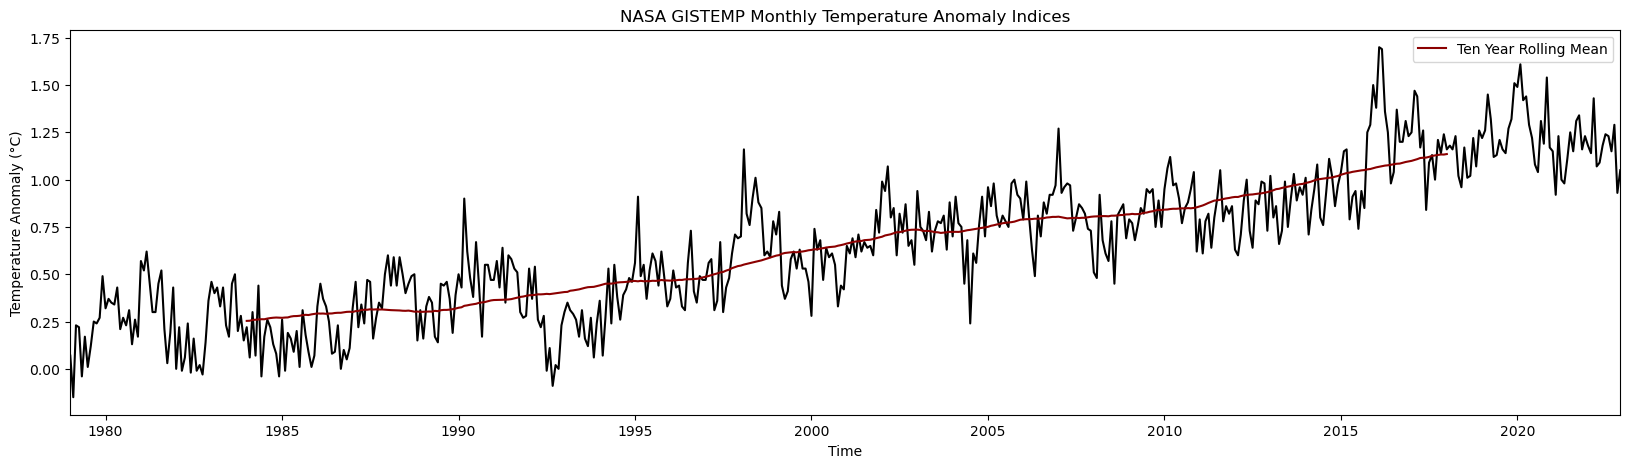

In [20]:
plt.figure(figsize=(20, 5))
temp_da.plot(color = 'black')
temp_da_rolling_10yr = temp_da.rolling(valid_time=120,center=True).mean().dropna(dim='valid_time') # take rolling 120 month mean (10 years)
temp_da_rolling_10yr.plot(color = 'darkred', marker = '', label = 'Ten Year Rolling Mean')
plt.xlabel('Time')
plt.legend()
plt.xlim(temp_da['valid_time'].min(), temp_da['valid_time'].max()) # fix x limit 
plt.title('NASA GISTEMP Monthly Temperature Anomaly Indices')
plt.show()

### * Perform linear regression between temperature anomalies and precipitation anomalies. 

#### This section of the project utilizes regression to analyze the relationship between higher temperatures (presumably the warming pattern observed in the GISTEMP, shown below). It is difficult to perform composite analysis here due to the very skewed positive anomalies, so it is likely a stronger method to perform regression to analyze regional sensitivities and changes to warming. 

### Here, temp is the independent variable and precipitation is the y variable.

In [22]:
x = temp_da.values
def compute_regression(precip_timeseries):
    slope, intercept, r_value, p_value, std_err = linregress(x, precip_timeseries)
    return slope, r_value

slope, r_val = xr.apply_ufunc( # the ufunc method allows for a function to be applied through specified dims, here it loops through each lat and lon and returns slope and r value
    compute_regression,  
    precip_anoms['tp'],     
    input_core_dims=[['valid_time']],  # operate over each time series for each grid cell 
    output_core_dims=[[], []], # output map values for each lat and lon 
    vectorize=True,              
    dask='allowed',             
)

In [23]:
slope.attrs['units'] = 'mm / °C' # slope is y / x 
# note regression coefficient (R) is unitless 

### * Plot the slope (m) and the temporal correlation coefficient (r val). 

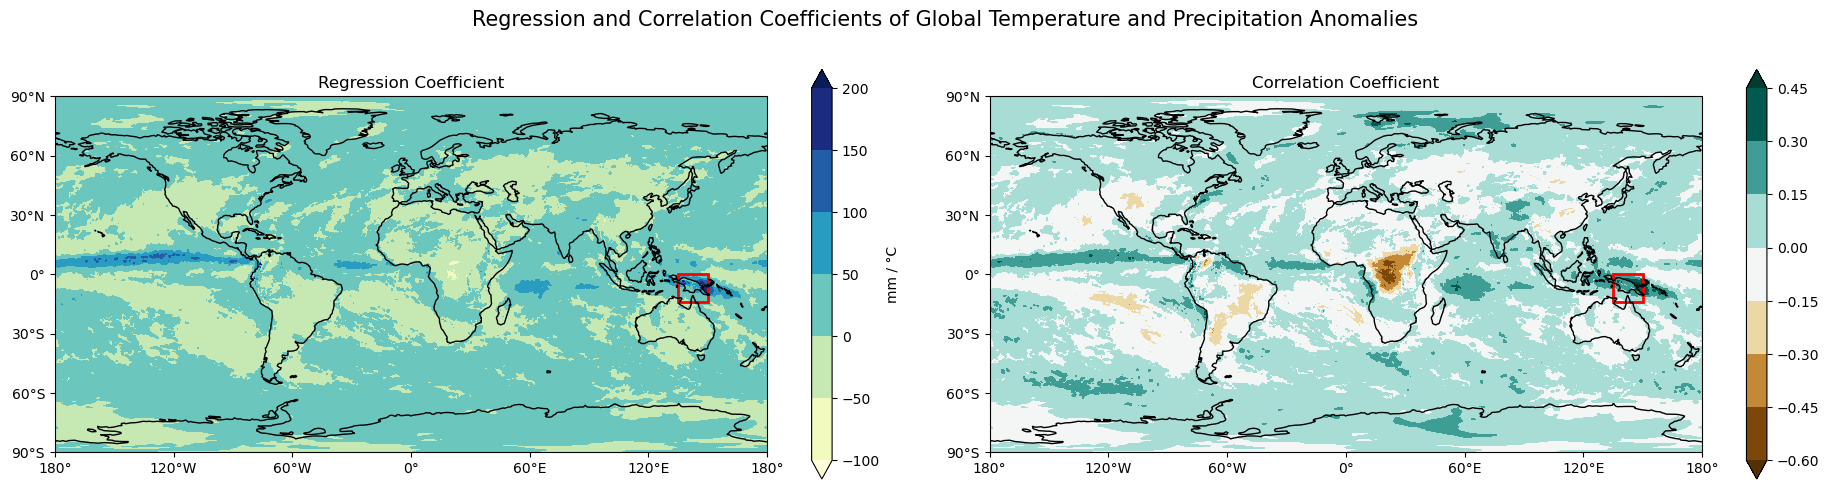

In [24]:
regression_terms = [slope, r_val]
units = [slope.attrs['units'], '']
labels = ['Regression Coefficient', 'Correlation Coefficient']
cmaps = ['YlGnBu', 'BrBG']
fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(19,6.5))

for i, terms in enumerate(regression_terms): 
        data = regression_terms[i]

        data,lons = add_cyclic_point(data,coord=regression_terms[i]['longitude'])

        cs=axs[i].contourf(lons,regression_terms[i]['latitude'],data,
                          transform = ccrs.PlateCarree(), cmap = cmaps[i],
                          extend='both')

        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        axs[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)
        cbar = plt.colorbar(cs,orientation='vertical',shrink=0.7, label = units[i])
        axs[i].add_patch(Rectangle((135, -14), 15, 14, fill=False,
        edgecolor='red',
        linewidth=2,
        transform=ccrs.PlateCarree() ))
        axs[i].set_title(labels[i])

        axs[i].coastlines()
plt.suptitle('Regression and Correlation Coefficients of Global Temperature and Precipitation Anomalies', y = .88, fontsize = 15)
plt.tight_layout()

### * Another analysis of interest is the general linear trend of precipitation change overtime. This allows us to see the global distribution of linear slopes of how precipitation is changing, which can provide insight on regions that seeing faster changes of precipitation. Note again that this data is only 43 years in terms of temporal frame, so the trend is more short-term. 

### The analysis below uses yearly means because linear regression cannot be applied to month values. Note again this is the mean of monthly precipitation for a year, meaning on average how much precip is seen in each month for a year (not yearly totals).

In [25]:
precip_anoms_yearlyavg = precip_anoms.groupby('valid_time.year').mean() # use yearly groupby to avoid problems of computing linear regression with month and datetime

def compute_slope(precip_timeseries): # write a function to compute trends for time series to be inputted into ufunc to go across each lat/lon
    time = precip_anoms_yearlyavg.year
    slope, intercept, r_value, p_value, std_err = linregress(time, precip_timeseries)
    return slope 

linear_trend = xr.apply_ufunc(
    compute_slope,  
    precip_anoms_yearlyavg['tp'],     
    input_core_dims=[['year']],  
    output_core_dims=[[]],   
    vectorize=True,              
    dask='allowed',             
)

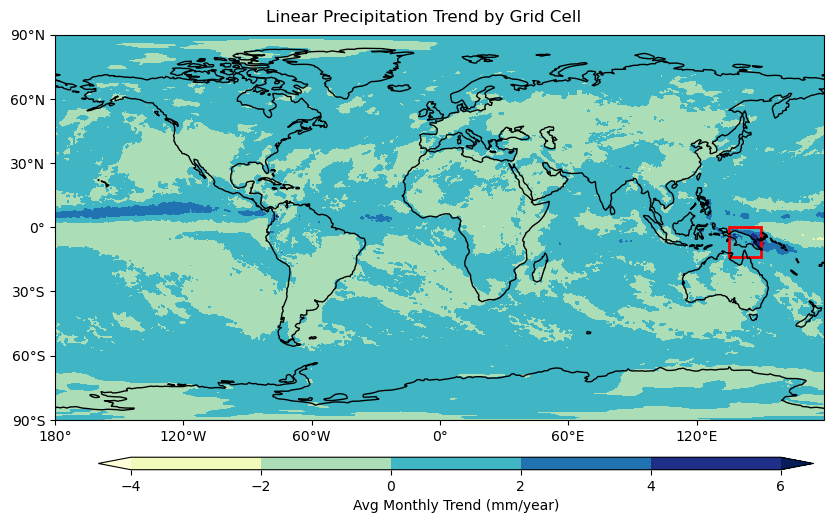

In [26]:
## mm per each month per year, can say mm/year after regression because the the yearly average represents average mm each month for the year - therefore this tells us how much wetter/drier the average month is getting by year
linear_trend.attrs['units'] = 'mm / year'
fig = plt.figure(figsize=(13, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
cs =ax.contourf(linear_trend['longitude'], linear_trend['latitude'], linear_trend, transform = ccrs.PlateCarree(), extend = 'both', cmap = 'YlGnBu') # this will fix the units issue to remove lingering units prior to applying ufunc
cbar_ax = fig.add_axes([0.25, 0.01, 0.55, 0.025])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='Avg Monthly Trend (mm/year)')
ax.coastlines()
plt.suptitle('Linear Precipitation Trend by Grid Cell', y=.93)
ax.add_patch(Rectangle((135, -14), 15, 14, fill=False,
        edgecolor='red',
        linewidth=2,
        transform=ccrs.PlateCarree() ))
plt.show()

 ## <center> <b> Part IV: Identification of Vulnerable Region (New Guinea) based on Forcings in Part II and Part III and Visualization of Extreme Precipiation Events.  <center> <b> 


## * Visualize and Subset Precipitation Anomalies of New Guinea to Hone in On This Region 

In [27]:
latitude_ng = slice(-14, 0)
longitude_ng = slice(135, 150)

# lat lon slices

In [28]:
precip_anoms_ng = precip_anoms.sel(latitude=latitude_ng, longitude=longitude_ng)
precip_anoms_ng 
weights = np.cos(np.deg2rad(precip_anoms_ng.latitude))
precip_anoms_ng_weighted = precip_anoms_ng.tp.weighted(weights)
precip_anoms_ng_regionalavg = precip_anoms_ng_weighted.mean(dim=("longitude", "latitude"))

# weight data and then take regional average 

### * Distributions for precipitation are not always normal and can be skewed negative or positive as discussed in class. To better understand the distribution especially when defining extreme events, the histogram is plotted. 

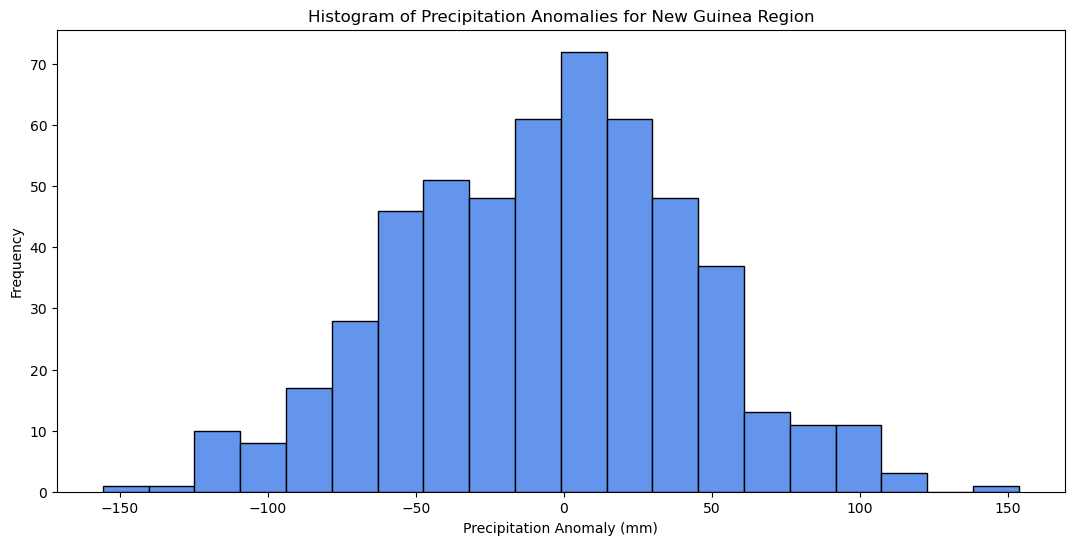

In [29]:
### Visualize Distribution Using Histogram 

plt.figure(figsize=(13,6))
plt.hist(
    precip_anoms_ng_regionalavg, 
    bins=20, # 20 "bins" of anomaly values to divide into
    color = 'cornflowerblue',
    edgecolor='black'
)
plt.ylabel('Frequency')
plt.xlabel('Precipitation Anomaly (mm)')
plt.title('Histogram of Precipitation Anomalies for New Guinea Region')
plt.show()

### * Surprisingly, the distribution is somewhat normal, but is slightly skewed to the left.

### * This next part delves into the analysis of how certain forcings might be connected to extreme events of rainfall, given that we have observed sensitivity of this region to both solar fluxes and temperature changes.

### * To define an extreme event, the function below picks a reference time period (1979-2000), takes a percentile within this period of precipitation and returns an array of a time series where precipitation exceeds this value ("the extreme"). Defining a reference period is common in precipitation extreme definitions and given a close to normal distribution, ensures that we do not simply output 5% of the counts. Here, we select the 95th percentile to define an extreme event.

In [30]:
# function to return time series of extreme events and also the threshold using reference period of 1979-2020
def define_extreme_rainfalls (precip_timeseries, percentile):
    reference = precip_timeseries.sel(valid_time=slice('1979-01-01T00:00:00.000000000', '2020-12-01T00:00:00.000000000'))
    extreme_thres = np.percentile(reference, percentile)
    precip_extremes = precip_timeseries.where(precip_timeseries>extreme_thres)
    return extreme_thres, precip_extremes

In [31]:
threshold, extremes_timeseries = define_extreme_rainfalls(precip_anoms_ng_regionalavg, 95)
print('The 95th percentile is: ', threshold)
print ('Number of Monthly Extreme Events: ', 29)

The 95th percentile is:  71.67470464054325
Number of Monthly Extreme Events:  29


### * Plot extreme event distribution and the threshold with the regional monthly anomaly backdrop.

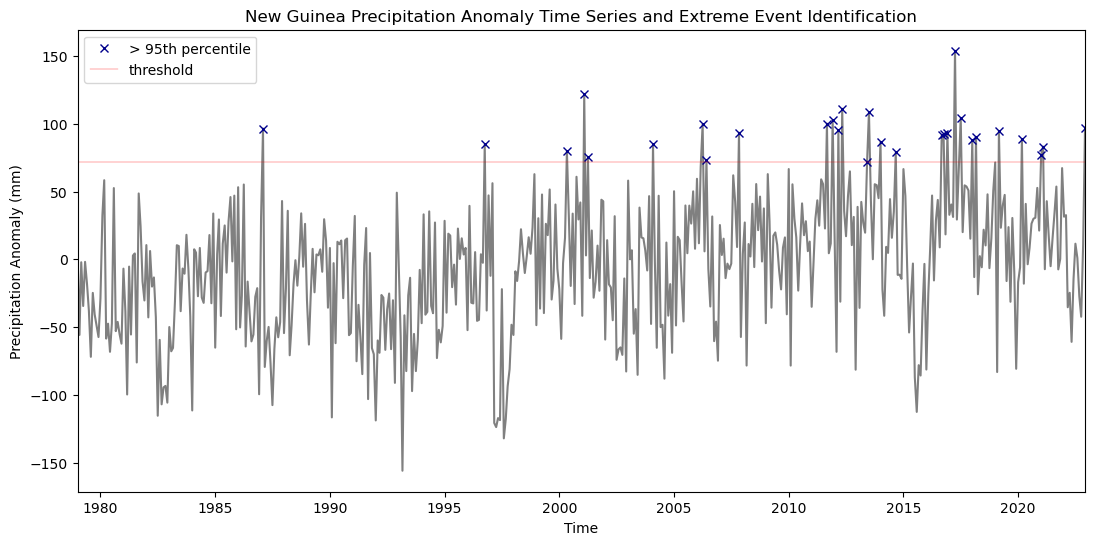

In [32]:
plt.figure(figsize=(13,6))
precip_anoms_ng_regionalavg.plot(color='grey')
extremes_timeseries.plot(marker='x', linestyle='', color = 'darkblue', label = '> 95th percentile')
plt.xlabel('Time')
plt.ylabel('Precipitation Anomaly (mm)')
plt.xlim(precip_anoms_ng_regionalavg['valid_time'].min(), precip_anoms_ng_regionalavg['valid_time'].max()) # fix x limit 
plt.axhline(threshold,color='red',linewidth=0.25, linestyle = '-', label = 'threshold')
plt.legend()
plt.title('New Guinea Precipitation Anomaly Time Series and Extreme Event Identification')
plt.show()

### * Given defined extreme events above, do these correspond to periods with a weak flux and/or warm temperatures as the statistical significance and regression may suggest? 

### * This plots the extreme events time series and highlights years where the solar flux is weak (recall our threshold is ≤ 100 sfu) and when the temperature anomaly is warm (here we define that as > .5 degree C). 

### * get all months that are not NaN in the extreme event time series that correspond to my forcing thresholds. Apply a function to identify all months where the forcing definitions match with extreme event months.

In [33]:
extremes_timeseries_wf = extremes_timeseries.where(weak_flux.notnull()) # need to use .notnull because otherwise the mask will return all extreme event years (likely a small caveat with masking)
extremes_timeseries_positivetemp = extremes_timeseries.where(temp_da>.5) 
extremes_timeseries_both = extremes_timeseries.where((weak_flux.notnull()) & (temp_da > .5)) 

## this function takes the time series above and returns month of the specific forcings if they align with an extreme event

def get_nonNanmonths(time_series): 
    notNantimes = time_series.valid_time[~np.isnan(time_series.values)]
    return notNantimes

month_weakflux  = get_nonNanmonths(extremes_timeseries_wf).values
month_postemp  = get_nonNanmonths(extremes_timeseries_positivetemp).values
month_both = get_nonNanmonths(extremes_timeseries_both).values

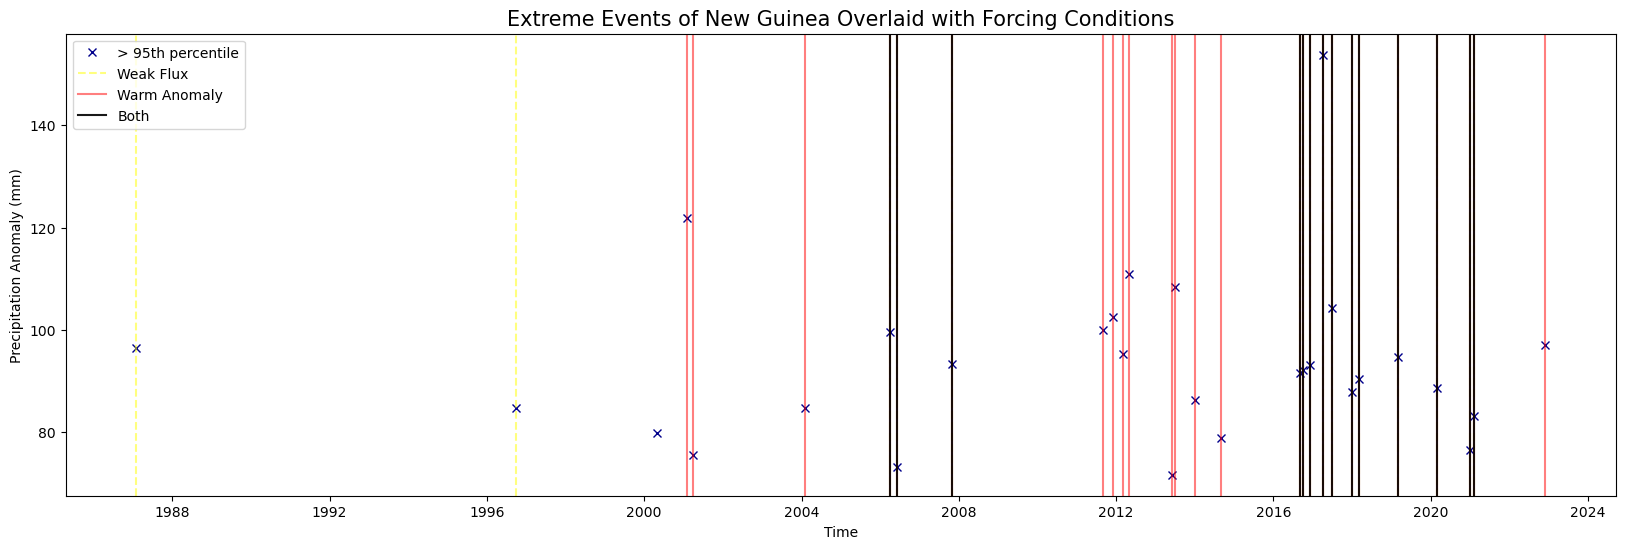

In [34]:
fig, ax = plt.subplots(figsize=(20,6))

extremes_timeseries.plot(marker='x', linestyle='', color = 'darkblue', label = '> 95th percentile')

# highlight vertical bars for years where forcins threshold were present 
# m loop is used to make sure legends appear only once (despite function looping over) 

# this sequence of what to plot over is selected to emphasize when both forcings are present.  
m = 1
for months in month_weakflux:
    ax.axvline(months, color='yellow', linestyle='--', alpha=0.5, label = 'Weak Flux' if m == 1 else None)
    m=m+1
m = 1
for months in month_postemp :
    ax.axvline(months, color='red', linestyle='-', alpha=0.5, label = 'Warm Anomaly' if m == 2 else None)
    m=m+1
m = 1
for months in month_both:
    ax.axvline(months, color='black', linestyle='-', alpha=0.9, label = 'Both' if m == 3 else None)
    m=m+1

plt.legend()
plt.title('Extreme Events of New Guinea Overlaid with Forcing Conditions', fontsize = 15)
plt.ylabel('Precipitation Anomaly (mm)')
plt.xlabel('Time')
plt.show()

## <center> <b>   Part V: Main Conclusions and Next Steps. <center> <b>


### Main findings from this report reveal insight on global precipitation patterns and gridded relationships between indices such as solar flux (external forcings) and temperature change (where the strong warming signal dominates). Through utilizing composites, we find that there are larger areas with statistically significant differences in monthly preciipitation when the solar flux is strong as opposed to weak. These regions are generally wetter. One region of interest is New Guinea and its surrounding waters, because it seems to get wetter with a weak solar flux and also show a statistically significant response to strong flux differences, which provides insight on it as a potential sensitiv region to solar flux changes.  

### Additionally, regressing against NASA GISTEMP anomalies finds significant relationships of precipitation changes as temperatures increase. Some regions exhibit a drying response while others see wetter conditions. The region of New Guinea sees one of the strongest regression (150 mm for each degree warmer) and correlation coefficients (about .40), with a positive relationship. In addition, linear trends of precipitation visualize how some regions might be seeing larger or smaller changes in precipitation in the temporal frame. We identify New Guinea as a hotspot, and analyze how extreme events (heavy rainfall) might relate to weak flux and warmer global anomalies, or both. 

### Results indicate that these forcings are present during most of the extreme events (mostly warm temperatures or both), although there is not a clear relationship on how the magnitude is affected. Further steps are needed to identify relationships between these variables, apply a dynamical conditions as to how these may lead to more rainfall, and to identify lag relationships of forcings with smaller temporal frames rather than monthly correlations (for example, could a preceding warmth lead to heavier rainfall? How would our findings change if we used daily time steps?) As discussed in class, composites and regressions may provide information of certain conditions affecting a variable, although solid conclusions require larger time frames and more thorough statistical and trend analysis.
